#### Диффузионные модели (Denoising Diffusion Models)

В текущем домашем задании предлагается закрепить знания и навыки построения и обучения диффузионных моделей на практике.

ФИО: Червоников Алексей Викторович

#### Задание

0. Скачайте репозиторий git clone [https://github.com/awjuliani/pytorch-diffusion.git](https://github.com/awjuliani/pytorch-diffusion.git)

1. Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2. Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance [https://arxiv.org/abs/2207.12598](https://arxiv.org/abs/2207.12598). (2 балла)

3. Обучите модель в режиме inpainting. Параграф 4.1 в [https://arxiv.org/pdf/2201.09865.pdf](https://arxiv.org/pdf/2201.09865.pdf). (1 балл)

#### Решение

Импортируем необходимые библиотеки

In [ ]:
pip install pytorch-lightning

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

from torch.autograd import Variable

from tqdm.auto import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

Device

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


0. Скачайте репозиторий git clone [https://github.com/awjuliani/pytorch-diffusion.git](https://github.com/awjuliani/pytorch-diffusion.git)

In [5]:
!git clone https://github.com/awjuliani/pytorch-diffusion.git

Cloning into 'pytorch-diffusion'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 15), reused 29 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.48 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [6]:
import sys
sys.path.append('/kaggle/working/pytorch-diffusion')

Объявим Config

In [7]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 128
config.num_epochs = 10
config.label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
] # Метки для датасета Fashion MNIST

1. Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

Необходимо реализовать классическое обучение, как это показано в рамках репозитория (Код работает из коробки)

In [8]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

Гиперпараметры модели

In [9]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = config.num_epochs
batch_size = config.batch_size

# Loading parameters
load_model = False
load_version_num = 1

Так реализуется загрузка модели

In [10]:
# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

Подготовка датасета выглядит следующим образом

In [11]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)



100%|██████████| 26421880/26421880 [00:00<00:00, 113307939.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4232593.09it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 60940008.70it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10705144.77it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [12]:
for batch in train_loader:
    # images, labels = batch
    # print(images.shape)
    # print(labels.shape)
    print(batch.size())
    break

torch.Size([128, 1, 32, 32])


Далее необходимо инициализировать модель PytorchLightning

In [12]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    accelerator = device,
    # gpus=1, 
    # auto_select_gpus=True,
    # resume_from_checkpoint=last_checkpoint, 
    logger=tb_logger
)

Запуск обучения

In [21]:
# Train model
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Обучение произошло. Запускаем инференс

In [38]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10

# Generate samples from denoising process
gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range-1, 0, -1)
for t in tqdm(sample_steps):
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

  0%|          | 0/999 [00:00<?, ?it/s]

In [39]:
x.size(), sample_steps.size()

(torch.Size([9, 1, 32, 32]), torch.Size([999]))

In [40]:
# Process samples and save as gif (Из коробки)
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

gen_samples = gen_samples.squeeze(-1)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples),
    fps=5,
)

In [41]:
gen_samples.size()

torch.Size([29, 96, 96])

Гифка сохранилась, посмотрим на изображения, которые получились в начале, середине и конце

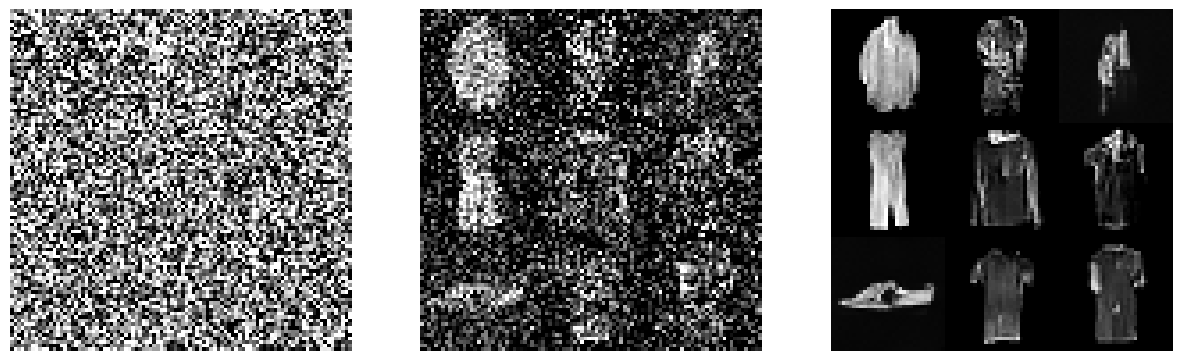

In [45]:
images = [list(gen_samples)[0], list(gen_samples)[15], list(gen_samples)[28]]

# print(image_start.size())
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  
    ax.axis('off') 
    
plt.show()


По заданию сказано изменить seed, сделаем 3, чтобы не было долго

In [46]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
random_seeds = [42, 2003, 2024,]
n_hold_final = 10

# Массив для сохранения результатов по SEED'ам
all_results = []

# Проходимся по SEED'ам
for seed in random_seeds:
    
    # Устанавливаем SEED
    torch.manual_seed(seed)
    x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
    gen_samples = []
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in tqdm(sample_steps):
        x = model.denoise_sample(x, t)
        if t % 50 == 0:
            gen_samples.append(x)
    for _ in range(n_hold_final):
        gen_samples.append(x)

    gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
    gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2  
    all_results.append((seed, gen_samples))

print('Generation finished!')

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

Generation finished!


Теперь генерируем гифки и выводим результаты обратного диффузионного процесса

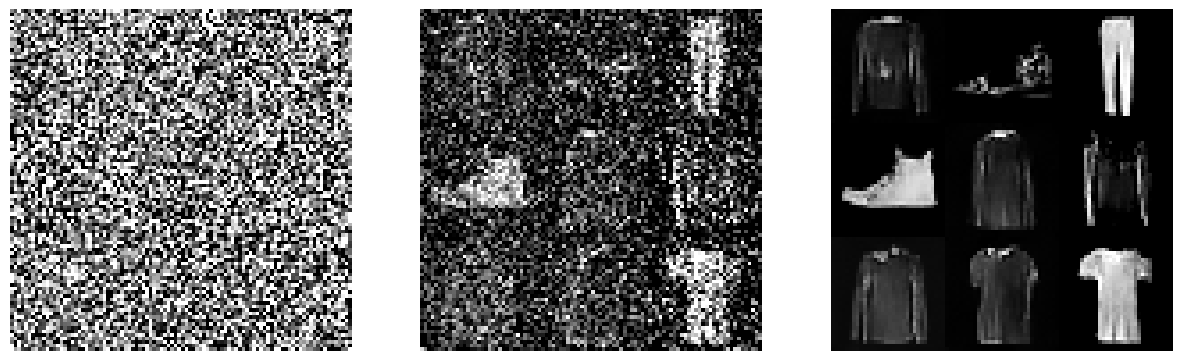

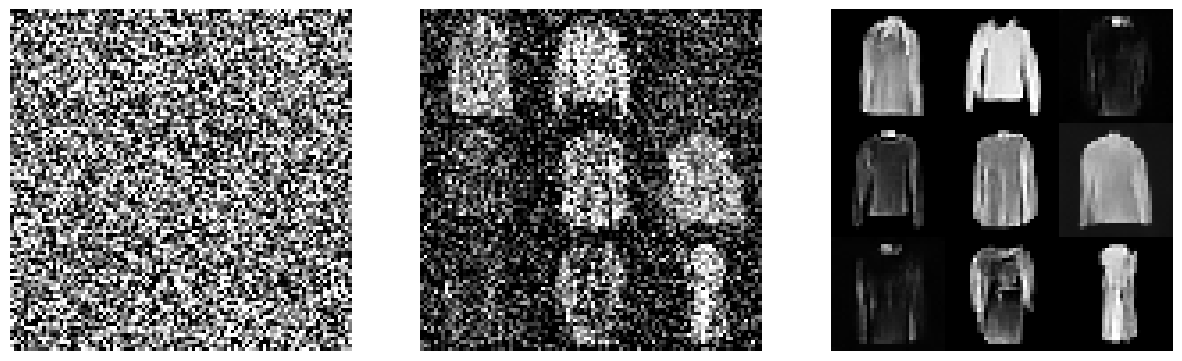

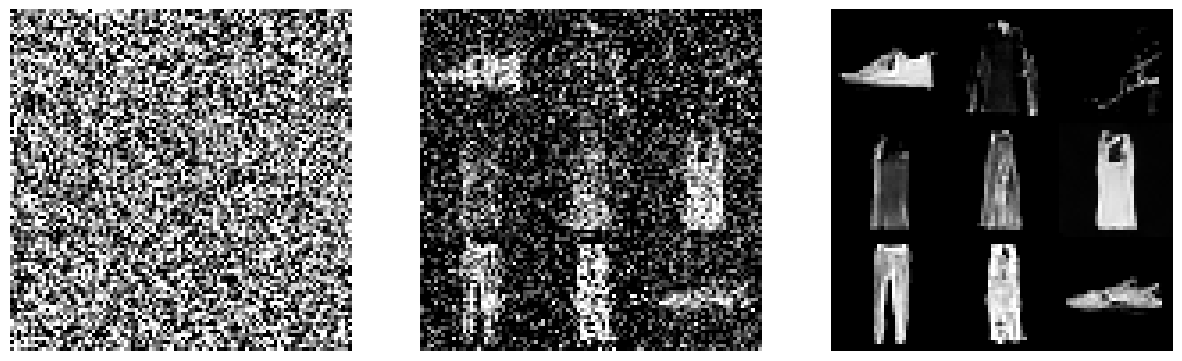

In [47]:
# Creating GIFs for each SEED and generated stack of images
for seed, gen_samples in all_results:
    gen_samples = (gen_samples * 255).type(torch.uint8)
    gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

    gen_samples = stack_samples(gen_samples, 2)
    gen_samples = stack_samples(gen_samples, 2)
    
    gen_samples = gen_samples.squeeze(-1)

    # Saving GIF
    imageio.mimsave(
        f"{trainer.logger.log_dir}/pred_seed_{seed}.gif",
        list(gen_samples),
        fps=5,
    )

    # Plotting results
    images = [list(gen_samples)[0], list(gen_samples)[15], list(gen_samples)[28]]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')  
        ax.axis('off') 
        
    plt.show()


Итак, все работает! ✅

2. Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance [https://arxiv.org/abs/2207.12598](https://arxiv.org/abs/2207.12598). (2 балла)

Для того, чтобы это все завелось, необходимо изменить логику обучения внутри предоставленного репозитория. В частности необходимо изменить методы класса ```DiffusionModel(pl.LightningModule)```

Датасет из репозитория почему-то не содержал меток, поэтому переустановим датасет

In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  
    torchvision.transforms.ToTensor(),  
])

In [14]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=transform, download=True)
val = torchvision.datasets.FashionMNIST("fashion_mnist", train=False, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12229683.96it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210352.35it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3888437.36it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11754097.44it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [15]:
train_dataloader = DataLoader(train, batch_size=config.batch_size, num_workers=4, shuffle=True)
val_dataloader = DataLoader(val, batch_size=config.batch_size, num_workers=4, shuffle=True)

In [16]:
for image, cat in train_dataloader:
    print(image.shape)
    print(cat.shape)
    break

for image, cat in val_dataloader:
    break

torch.Size([128, 1, 32, 32])
torch.Size([128])


tensor(1)


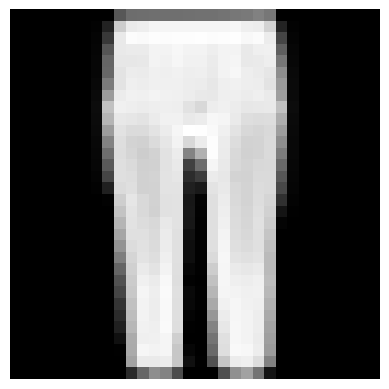

In [17]:
for image, cat in train_dataloader:
    # print(cat)
    image_np = image[0].squeeze().numpy() 

    print(cat[0])
    plt.imshow(image_np, cmap='gray')  
    plt.axis('off') 
    plt.show()
    break

Теперь заменим исходную реализацию на обновленную

In [76]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        Слой эмбеддера (позволяет динамически закодировать метку к требуемому torch.size())
        Эта операция зашивает информацию по метке к информации SegNet (Down и Up) + pos_encoding
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.embed_dim = emb_dim
        self.model = nn.Sequential(*layers)

    def forward(self, x, embed_size):
        x = x.view(-1, self.input_dim)
        x = self.model(x)
        output_embedding = x.view(-1, self.embed_dim, 1, 1).repeat(1, 1, embed_size, embed_size)
        return output_embedding
        
class CustomDiffusionModel(DiffusionModel):
    '''Модель наследник от исходной'''
    def __init__(self, in_size, t_range, img_depth, p_uncond = 0.1, 
                 num_classes = 10):
        super(CustomDiffusionModel, self).__init__(in_size, t_range, img_depth)
        self.p_uncond = p_uncond
        self.num_classes = num_classes
        self.in_size = in_size
        
		# Объявляем слои эмбеддера
        self.embedding_layer1 = EmbedFC(self.num_classes, 128).to(device)
        self.embedding_layer2 = EmbedFC(self.num_classes, 256).to(device)
        self.embedding_layer3 = EmbedFC(self.num_classes, 256).to(device)
        self.embedding_layer4 = EmbedFC(self.num_classes, 128).to(device)
        self.embedding_layer5 = EmbedFC(self.num_classes, 64).to(device)
        self.embedding_layer6 = EmbedFC(self.num_classes, 64).to(device)
        
        

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        # print(f"T {t.size()}")
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        # print(f"Pos_encoding_a: {pos_enc_a.size()}")
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def label_encoding(self, labels, channels, embed_size):
        embed = EmbedFC(self.num_classes, channels).to(device)
        output = embed(labels)
        output_embedding = output.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)
        # -> Output size: [batch_size, num_channels, embed_size, embed_size]
        return output_embedding
        
    

    def forward(self, x, t, c, context_mask):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """

        c = nn.functional.one_hot(c, num_classes=self.num_classes).type(torch.float).to(device)
        # print(f"OHE output shape: {c.shape}")
        # context_mask = context_mask[:, None]
        # context_mask = context_mask.repeat(1,self.n_classes)
        # context_mask = (-1*(1-context_mask)) 
        # c = c * context_mask
        # print(f"Embedding size: {embed.size()}")
        # print(f"C before: {c}")

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.num_classes)
        context_mask = (-1*(1-context_mask)) 
        c = c * context_mask
        # print(f"C after: {c}")
        

        # print(f"Input x size: {x.size()}")
        x1 = self.inc(x)
        # print(f"After DoubleConv: {x1.size()}")
        # print(f"Two operations: {self.down1(x1).size()} and {self.pos_encoding(t, 128, 16).size()}")
        # print(self.emedding_layer1(c, 16).size())
        
		# И здесь дополнительно зашиваем информацию
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.embedding_layer1(c, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.embedding_layer2(c, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.embedding_layer3(c, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.embedding_layer4(c, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.embedding_layer5(c, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.embedding_layer6(c, 32)
        output = self.outc(x)
        # print(output.shape)
        return output

    def get_loss(self, batch, batch_idx):
        '''Логика из статьи Classifier Free Guidance https://arxiv.org/abs/2207.1259'''
        images, labels = batch  # Уже с учетом меток
        ts = torch.randint(0, self.t_range, [images.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(images.shape, device=self.device)
        context_mask = torch.bernoulli(torch.zeros_like(labels)+self.p_uncond).to(self.device)
        
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * images[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float), 
                             labels, context_mask)
        
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, x, t, labels, context_mask, guide_w = 0.5, n_samples = 9):
        '''Логика из статьи Classifier Free Guidance https://arxiv.org/abs/2207.12598'''
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x[:n_samples].shape).to(device)
            else:
                z = 0
                
			# Комбинирование labeled и non-labeled сэмплов данных
            eps1 = self.forward(x[:n_samples], 
                                 t.view(1, 1).repeat(x[:n_samples].shape[0], 1), labels[:n_samples], 
                                context_mask[:n_samples])

            # print(x[n_samples:].size())
            # print(labels[n_samples:].size())
            # print(t.view(1, 1).repeat(x[n_samples:].shape[0], 1).size())
            # print()
            eps2 = self.forward(x[n_samples:], 
                                 t.view(1, 1).repeat(x[n_samples:].shape[0], 1), labels[n_samples:], 
                                context_mask[n_samples:])
            eps = (1+guide_w)*eps1 - guide_w*eps2
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            # print(x[:n_samples].size(), eps.size())
            x = pre_scale * (x[:n_samples] - e_scale * eps) + post_sigma
            return x

    
            

Инициализируем новую модель

In [77]:
model_upd = CustomDiffusionModel(train_dataset.size*train_dataset.size, 
                           diffusion_steps, 
                           train_dataset.depth).to(device)

In [78]:
for name, param in model_upd.named_parameters():
    print(f"Parameter: {name}, Requires Grad: {param.requires_grad}, Shape: {param.shape}")


Parameter: inc.double_conv.0.weight, Requires Grad: True, Shape: torch.Size([64, 1, 3, 3])
Parameter: inc.double_conv.1.weight, Requires Grad: True, Shape: torch.Size([64])
Parameter: inc.double_conv.1.bias, Requires Grad: True, Shape: torch.Size([64])
Parameter: inc.double_conv.3.weight, Requires Grad: True, Shape: torch.Size([64, 64, 3, 3])
Parameter: inc.double_conv.4.weight, Requires Grad: True, Shape: torch.Size([64])
Parameter: inc.double_conv.4.bias, Requires Grad: True, Shape: torch.Size([64])
Parameter: down1.maxpool_conv.1.double_conv.0.weight, Requires Grad: True, Shape: torch.Size([64, 64, 3, 3])
Parameter: down1.maxpool_conv.1.double_conv.1.weight, Requires Grad: True, Shape: torch.Size([64])
Parameter: down1.maxpool_conv.1.double_conv.1.bias, Requires Grad: True, Shape: torch.Size([64])
Parameter: down1.maxpool_conv.1.double_conv.3.weight, Requires Grad: True, Shape: torch.Size([64, 64, 3, 3])
Parameter: down1.maxpool_conv.1.double_conv.4.weight, Requires Grad: True, Shap

Пробуем запустить обучение для неё

In [79]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/model_upd/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    accelerator = device,
    # gpus=1, 
    # auto_select_gpus=True,
    # resume_from_checkpoint=last_checkpoint, 
    logger=tb_logger
)

In [80]:
trainer.fit(model_upd, train_dataloader, val_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Пробуем запустить инференс

In [86]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 10
gen_samples = []

x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size)).to(device)
sample_steps = torch.arange(model_upd.t_range-1, 0, -1).to(device)

labels = torch.arange(0, 9).to(device)  
guide_weight = 0.5  
context_mask = torch.zeros_like(labels).to(device)
labels = labels.repeat(2)
context_mask = context_mask.repeat(2)
context_mask[sample_batch_size:] = 1. 
# x = x.repeat(2,1,1,1)
# print(x.size())
# print(labels.size())
model_upd = model_upd.to(device)

for t in tqdm(sample_steps):
    x = x.repeat(2,1,1,1)
    x = model_upd.denoise_sample(x, t, labels, context_mask, guide_w = 2)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

  0%|          | 0/999 [00:00<?, ?it/s]

In [87]:
gen_samples.size()

torch.Size([29, 9, 32, 32])

In [88]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

gen_samples = gen_samples.squeeze(-1)

# imageio.mimsave(
#     f"generated.gif",
#     list(gen_samples.cpu()),
#     fps=5,
# )

In [89]:
gen_samples.size()

torch.Size([29, 96, 96])

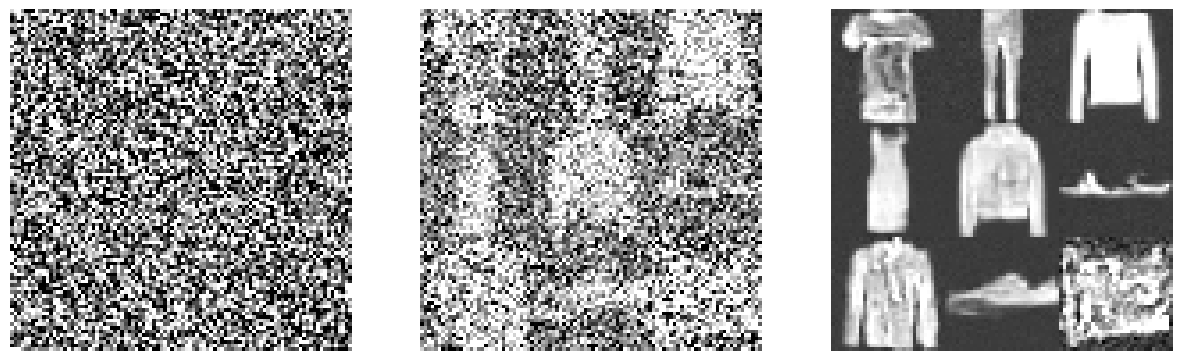

In [90]:
images = [list(gen_samples.cpu())[0], list(gen_samples.cpu())[15], list(gen_samples.cpu())[28]]

# print(image_start.size())
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')  
    ax.axis('off') 
    
plt.show()


```python 
config.label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]
```

Виузально все соответствует

In [223]:
gen_samples.size()

torch.Size([29, 96, 96])

В общем, условная генерация сработала корректно! ✅

3. Обучите модель в режиме inpainting. Параграф 4.1 в [https://arxiv.org/pdf/2201.09865.pdf](https://arxiv.org/pdf/2201.09865.pdf). (1 балл)

Нужно переопределить функцию get_loss() исходного класса. Аналогично пишем класс-наследник

In [115]:
import random

class InpaintingDiffusionModel(DiffusionModel):
    '''Модель наследник от исходной'''
    def __init__(self, in_size, t_range, img_depth, p_uncond = 0.1, 
                 num_classes = 10):
        super(InpaintingDiffusionModel, self).__init__(in_size, t_range, img_depth)

    def get_loss(self, batch, batch_idx):
        """
        Соответствует классическому правилу Марковских цепей (цитата из статьи Inpainting https://arxiv.org/pdf/2201.09865.pdf)
        """
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss
        
    def denoise_sample(self, x, t, mask):
        """
        Денойзинг с маскированием (Inpainting https://arxiv.org/pdf/2201.09865.pdf)
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape).to(device)
            else:
                z = 0
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1))
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            denoised_x = pre_scale * (x - e_scale * e_hat) + post_sigma

            # Учёт маски
            x = x * mask + denoised_x * (1 - mask)
            return x


Инициализируем модель

In [120]:
model_inpainting = InpaintingDiffusionModel(train_dataset.size*train_dataset.size, 
                           diffusion_steps, 
                           train_dataset.depth).to(device)

Попробуем обучить все это дело:

In [121]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    accelerator = device,
    # gpus=1, 
    # auto_select_gpus=True,
    # resume_from_checkpoint=last_checkpoint, 
    logger=tb_logger
)

run

In [122]:
trainer.fit(model_inpainting, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Пробуем сделать инференс (денойзинг):

Inpainting image 1:   0%|          | 0/999 [00:00<?, ?it/s]

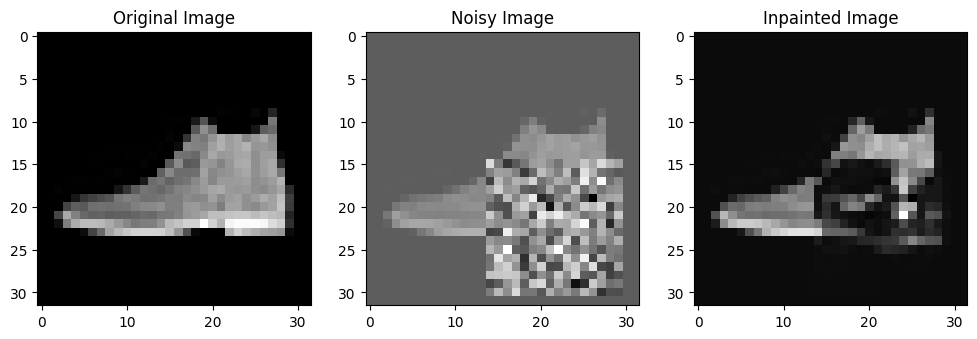

Inpainting image 2:   0%|          | 0/999 [00:00<?, ?it/s]

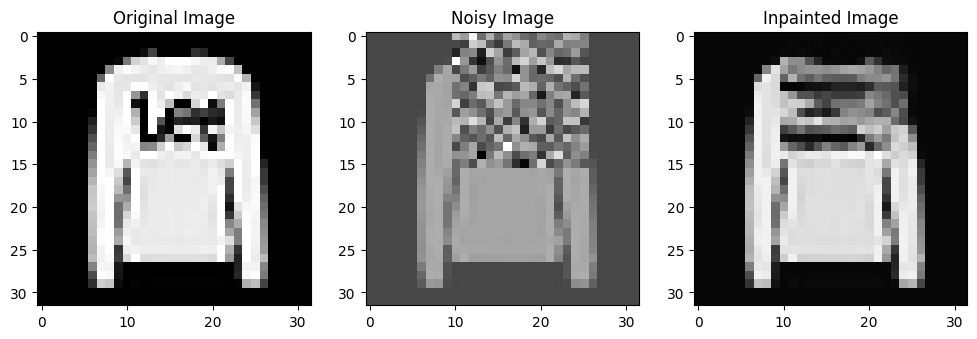

Inpainting image 3:   0%|          | 0/999 [00:00<?, ?it/s]

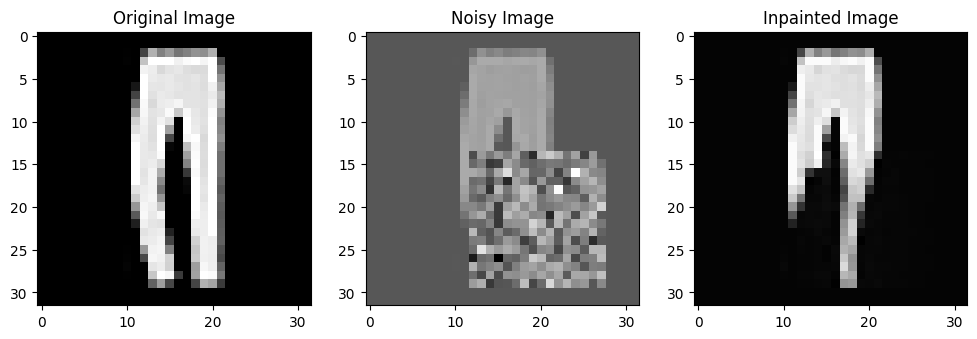

Inpainting image 4:   0%|          | 0/999 [00:00<?, ?it/s]

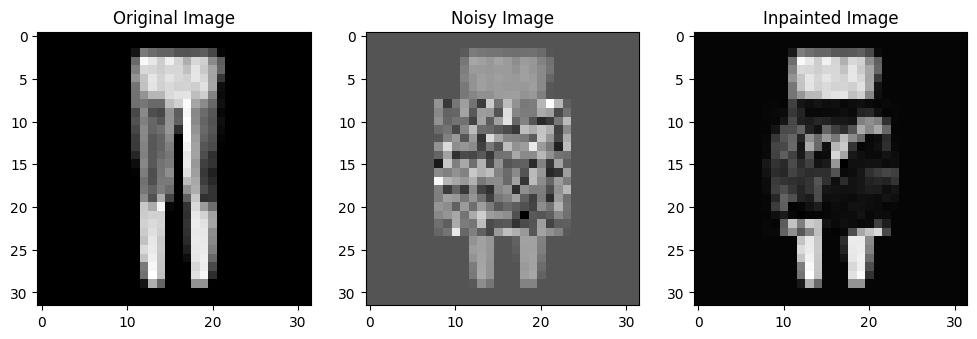

Inpainting image 5:   0%|          | 0/999 [00:00<?, ?it/s]

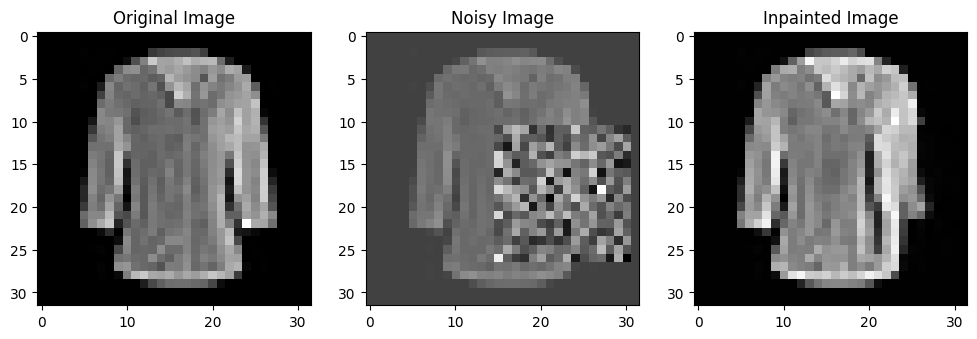

Inpainting image 6:   0%|          | 0/999 [00:00<?, ?it/s]

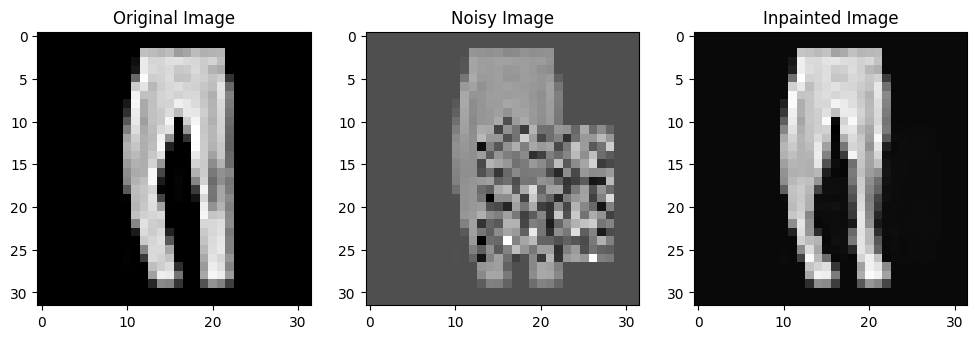

Inpainting image 7:   0%|          | 0/999 [00:00<?, ?it/s]

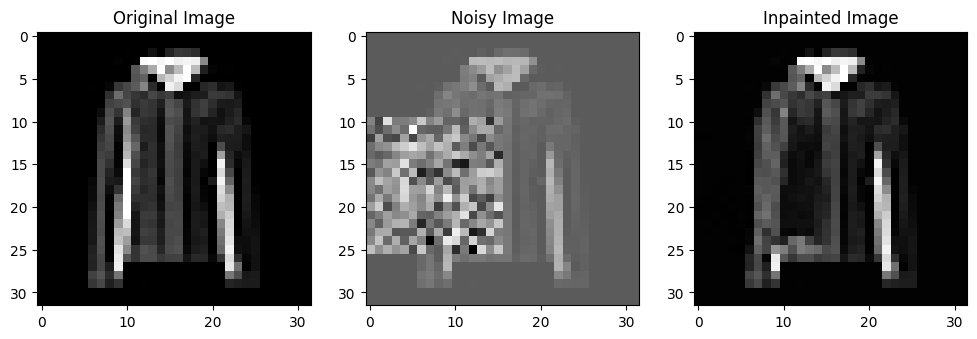

Inpainting image 8:   0%|          | 0/999 [00:00<?, ?it/s]

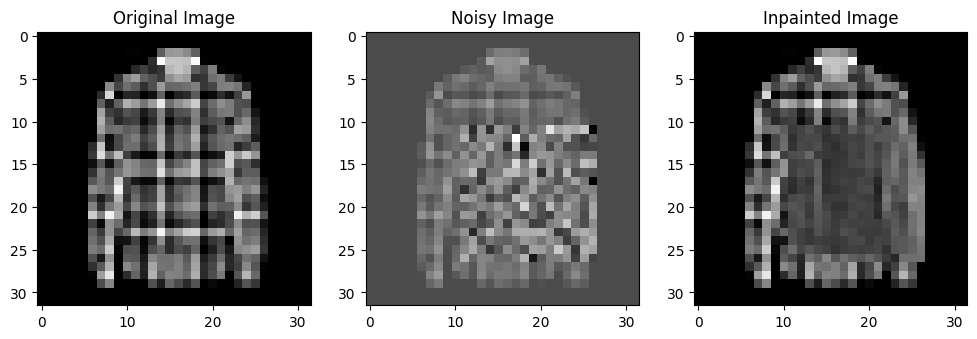

Inpainting image 9:   0%|          | 0/999 [00:00<?, ?it/s]

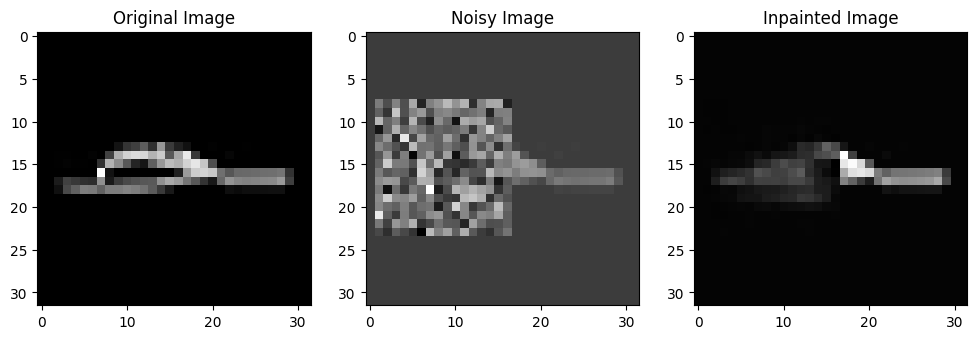

In [124]:
def inpaint_image(model, dataset, num_samples=1):
    """
    Восстановление замскированного изображения 
    """
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i in range(num_samples):
            
            x = dataset[i].unsqueeze(0).to(device)
            # print(x.shape)
            B, C, H, W = x.shape
            mask_height, mask_width = H // 2, W // 2
            y1 = random.randint(0, H - mask_height)  
            x1 = random.randint(0, W - mask_width)  
            y2 = y1 + mask_height 
            x2 = x1 + mask_width 
            
            mask = torch.ones_like(x).to(device)
            mask[:, :, y1:y2, x1:x2] = 0  
            t = model.t_range  
            noisy_x = x.clone()
            noise = torch.randn_like(x)  
            noisy_x = noisy_x * mask + noise * (1 - mask) 
           
            sample_steps = torch.arange(model.t_range - 1, 0, -1)  
            denoised_x = noisy_x.clone()
            for t in tqdm(sample_steps, desc=f"Inpainting image {i+1}"):
                denoised_x = model.denoise_sample(denoised_x, torch.tensor(t).to(device), mask)
            
            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(x.squeeze(0).permute(1, 2, 0).cpu(), cmap='gray')
            ax[0].set_title("Original Image")
            ax[1].imshow(noisy_x.squeeze(0).permute(1, 2, 0).cpu(), cmap='gray')
            ax[1].set_title("Noisy Image")
            ax[2].imshow(denoised_x.squeeze(0).permute(1, 2, 0).cpu(), cmap='gray')
            ax[2].set_title("Inpainted Image")
            plt.show()

inpaint_image(model_inpainting, val_dataset, num_samples = 9) 

In [26]:
val_dataset[0].size()

torch.Size([1, 32, 32])

В целом, релевантные дорисовки. Можно еще потюнить для повышения визуального качетсва, но оно работает! ✅